# 6. Задача регрессии

**Выбор датасета для регрессии:**
   - Выберите датасет из репозитория UCI (Archive) для задачи регрессии с количеством данных **>1000 и количеством признаков >8**.
   - Обучите модель `CatBoostRegressor` и оцените её точность с использованием всех доступных метрик.

In [1]:
import funcs as fn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Загрузка данных

In [2]:
df=fn.get_wine_data()

In [3]:
df.sample(10)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,color
134,7.9,1.04,0.05,2.20,0.084,13.0,29.0,0.99590,3.22,0.55,9.9,6,red
3741,7.5,0.26,0.52,13.20,0.047,64.0,179.0,0.99820,3.10,0.46,9.0,5,white
2649,7.3,0.24,0.34,7.50,0.048,29.0,152.0,0.99620,3.10,0.54,9.0,5,white
1974,5.1,0.33,0.22,1.60,0.027,18.0,89.0,0.98930,3.51,0.38,12.5,7,white
2770,8.2,0.61,0.45,5.40,0.030,15.0,118.0,0.99540,3.14,0.34,9.6,5,white
1609,8.1,0.27,0.41,1.45,0.033,11.0,63.0,0.99080,2.99,0.56,12.0,5,white
2222,7.2,0.24,0.34,1.10,0.045,3.0,64.0,0.99130,3.23,0.51,11.4,5,white
1307,6.8,0.68,0.09,3.90,0.068,15.0,29.0,0.99524,3.41,0.52,11.1,4,red
1523,6.8,0.48,0.25,2.00,0.076,29.0,61.0,0.99530,3.34,0.60,10.4,5,red
4796,7.9,0.34,0.44,6.50,0.027,47.0,126.0,0.99124,2.96,0.37,12.5,6,white


## Создание базовой модели

In [4]:
target='alcohol'

In [5]:
df.nunique()

fixed acidity           106
volatile acidity        187
citric acid              89
residual sugar          316
chlorides               214
free sulfur dioxide     135
total sulfur dioxide    276
density                 998
pH                      108
sulphates               111
alcohol                 111
quality                   7
color                     2
dtype: int64

In [6]:
cat_cols=['quality', 'color']

In [7]:
base_model, X_train, y_train, X_test, y_test, model_metrics = fn.build_model(df, cat_cols, type='regressor', target=target)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

mae_train: 0.2878, mae_test: 0.3267
mse_train: 0.1401, mse_test: 0.189
rmse_train: 0.3742, rmse_test: 0.4348
mape_train: 0.0276, mape_test: 0.0312
r2_train: 0.9013, r2_test: 0.8682
adj_r2_train: 0.9011, adj_r2_test: 0.867


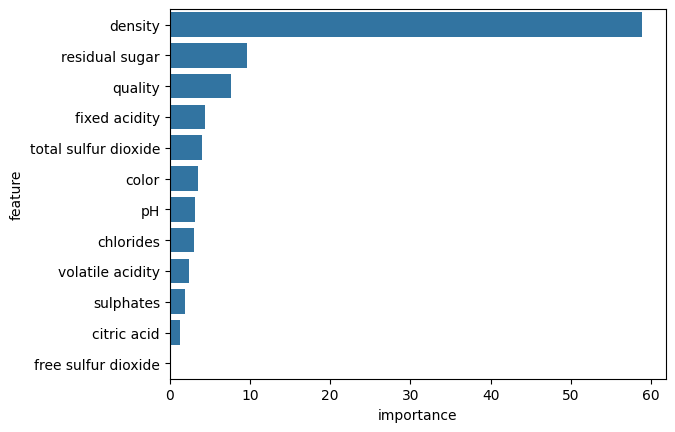

In [8]:
base_feature_importance=fn.get_feature_importance(base_model, X_train.columns)
fn.plot_feature_importance(base_feature_importance)

> Судя по всему, через `density` является явным индикатором уровня алкоголя и это приводит к data_leakage.

In [9]:
df_2=df.drop(['density'], axis=1).copy()

## EDA

In [10]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   pH                    6497 non-null   float64
 8   sulphates             6497 non-null   float64
 9   alcohol               6497 non-null   float64
 10  quality               6497 non-null   int64  
 11  color                 6497 non-null   object 
dtypes: float64(10), int64(1), object(1)
memory usage: 609.2+ KB


In [11]:
df_2.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
fixed acidity,6497.0,7.22,1.30,3.80,6.40,7.00,7.70,15.90
volatile acidity,6497.0,0.34,0.16,0.08,0.23,0.29,0.40,1.58
citric acid,6497.0,0.32,0.15,0.00,0.25,0.31,0.39,1.66
residual sugar,6497.0,5.44,4.76,0.60,1.80,3.00,8.10,65.80
chlorides,6497.0,0.06,0.04,0.01,0.04,0.05,0.06,0.61
free sulfur dioxide,6497.0,30.53,17.75,1.00,17.00,29.00,41.00,289.00
total sulfur dioxide,6497.0,115.74,56.52,6.00,77.00,118.00,156.00,440.00
pH,6497.0,3.22,0.16,2.72,3.11,3.21,3.32,4.01
sulphates,6497.0,0.53,0.15,0.22,0.43,0.51,0.60,2.00
alcohol,6497.0,10.49,1.19,8.00,9.50,10.30,11.30,14.90


In [13]:
corr=df_2.drop(cat_cols, axis=1).corr()

In [14]:
corr_ranks=(
    corr[[target]]
    .assign(abs_corr=lambda d_: d_[target].abs())
    .sort_values(by=['abs_corr'], ascending=False)
    .iloc[1:]
    .round(2)
)
corr_ranks

,alcohol,abs_corr
residual sugar,-0.36,0.36
total sulfur dioxide,-0.27,0.27
chlorides,-0.26,0.26
free sulfur dioxide,-0.18,0.18
pH,0.12,0.12
fixed acidity,-0.10,0.10
volatile acidity,-0.04,0.04
citric acid,-0.01,0.01
sulphates,-0.00,0.00


Проверяем на мультиколлинеарность

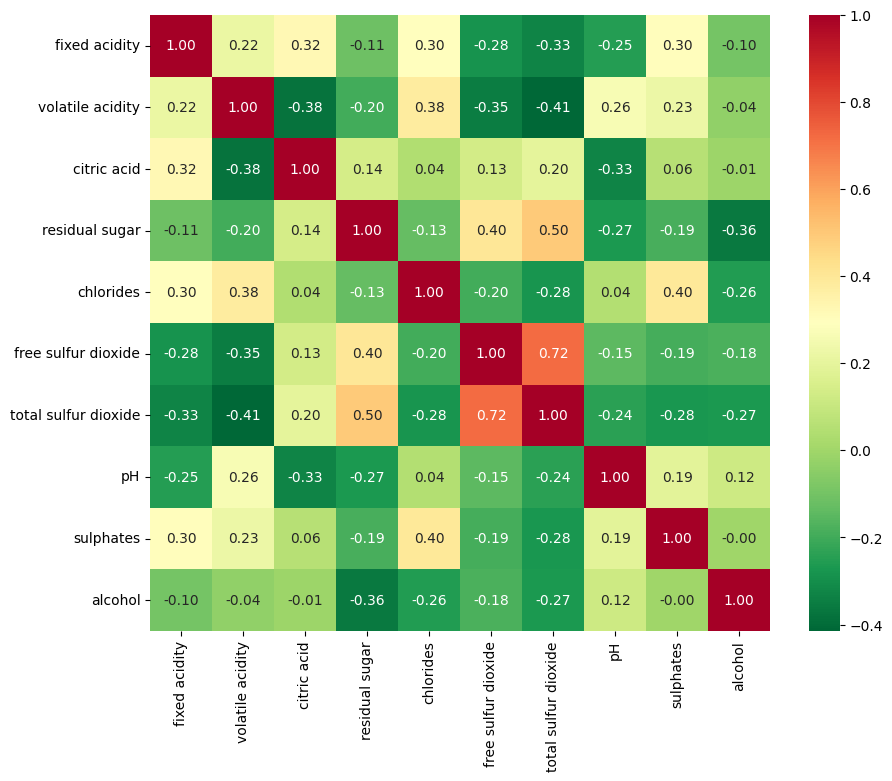

In [15]:
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr,
    annot=True,
    fmt='.2f',
    cmap='RdYlGn_r'
);

> прослеживается сильная корреляция между предикторами `free sulfur dioxide` и `total sulfur dioxide`.

In [16]:
cols_to_drop=['total sulfur dioxide']

In [17]:
model_2, X_train_2, y_train_2, X_test_2, y_test_2, model_metrics_2 = fn.build_model(df_2.drop(cols_to_drop, axis=1), cat_cols, type='regressor', target=target)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

mae_train: 0.556, mae_test: 0.6134
mse_train: 0.4966, mse_test: 0.6336
rmse_train: 0.7047, rmse_test: 0.796
mape_train: 0.0528, mape_test: 0.0579
r2_train: 0.6501, r2_test: 0.5582
adj_r2_train: 0.6494, adj_r2_test: 0.5548


Проверяем распределение целевой переменной по категориальным предикторам

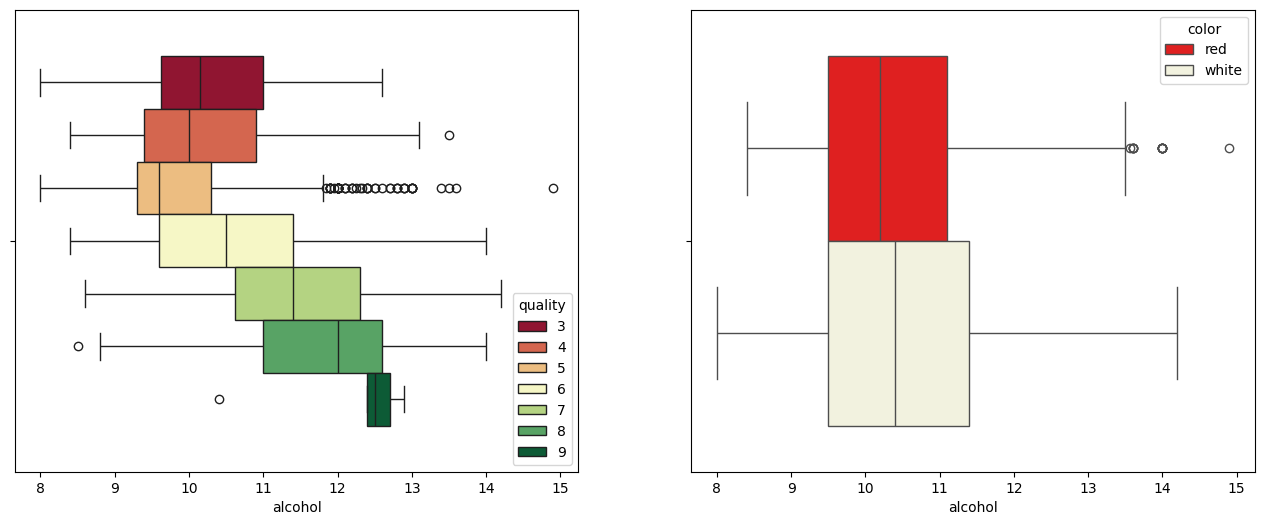

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.boxplot(data=df_2, x=target, hue='quality', palette='RdYlGn', ax=axes[0])
sns.boxplot(data=df_2, x=target, hue='color', ax=axes[1], palette=['red', 'beige'])

plt.show();

Проверяем на наличие пустых значений

In [19]:
df.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
color                   0
dtype: int64

Проверяем на выбросы

In [20]:
dsc=(
    df_2.describe().T
    .assign(
        iqr = lambda d_: d_['75%'] - d_['25%'],
        lbound = lambda d_: d_['25%'] - d_['iqr'] * 3,
        ubound = lambda d_: d_['75%'] + d_['iqr'] * 3
    )
).round(2)[['lbound', 'min', 'max', 'ubound']]
dsc

,lbound,min,max,ubound
fixed acidity,2.50,3.80,15.90,11.60
volatile acidity,-0.28,0.08,1.58,0.91
citric acid,-0.17,0.00,1.66,0.81
residual sugar,-17.10,0.60,65.80,27.00
chlorides,-0.04,0.01,0.61,0.15
free sulfur dioxide,-55.00,1.00,289.00,113.00
total sulfur dioxide,-160.00,6.00,440.00,393.00
pH,2.48,2.72,4.01,3.95
sulphates,-0.08,0.22,2.00,1.11
alcohol,4.10,8.00,14.90,16.70


In [21]:
outliers=pd.concat(
    list(map(
        lambda x: df_2[
            (df_2[x]<dsc.loc[x, 'lbound']) | (df_2[x]>dsc.loc[x, 'ubound'])
        ],
        df_2.drop(['color'], axis=1).columns
    ))
).drop_duplicates()

In [22]:
outliers

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,pH,sulphates,alcohol,quality,color
205,12.8,0.30,0.74,2.6,0.095,9.0,28.0,3.20,0.77,10.8,7,red
241,12.0,0.38,0.56,2.1,0.093,6.0,24.0,3.14,0.71,10.9,6,red
243,15.0,0.21,0.44,2.2,0.075,10.0,24.0,3.07,0.84,9.2,7,red
264,12.5,0.56,0.49,2.4,0.064,5.0,27.0,3.08,0.87,10.9,5,red
265,11.8,0.26,0.52,1.8,0.071,6.0,10.0,3.20,0.72,10.2,7,red
...,...,...,...,...,...,...,...,...,...,...,...,...
723,7.1,0.31,0.30,2.2,0.053,36.0,127.0,2.94,1.62,9.5,5,red
795,10.8,0.89,0.30,2.6,0.132,7.0,60.0,2.99,1.18,10.2,5,red
1158,6.7,0.41,0.43,2.8,0.076,22.0,54.0,3.42,1.16,10.6,6,red
1288,7.0,0.60,0.30,4.5,0.068,20.0,110.0,3.30,1.17,10.2,5,red


In [23]:
len(outliers)/len(df)

0.04140372479605972

## Создаём модель после очистки выбросов

In [24]:
no_out_df=df_2[~df_2.index.isin(outliers.index)].copy()

In [25]:
no_out_model, X_train_no, y_train_no, X_test_no, y_test_no, model_metrics_no = fn.build_model(no_out_df, cat_cols, type='regressor', target=target)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

mae_train: 0.5345, mae_test: 0.5926
mse_train: 0.465, mse_test: 0.5741
rmse_train: 0.6819, rmse_test: 0.7577
mape_train: 0.0506, mape_test: 0.0561
r2_train: 0.6736, r2_test: 0.6069
adj_r2_train: 0.6728, adj_r2_test: 0.6034


# 7. Анализ таргета по диапазонам

**Разбиение таргета на диапазоны:**
   - Разбейте **таргет** на 5 диапазонов вручную, не используя квантильное разбиение.
   - Для каждого диапазона выведите таблицу с количеством данных в этом диапазоне и посчитайте 3 метрики: `MAE`, `RMSE`, `MAPE`.

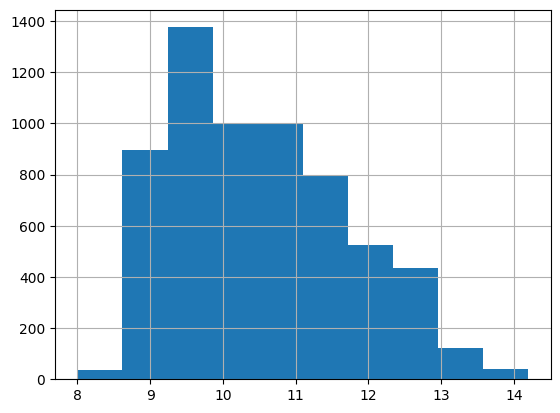

In [26]:
no_out_df[target].hist();

In [27]:
target_bins=pd.cut(no_out_df[target], bins=[-np.inf, 9, 10, 11, 13, +np.inf], labels=['<=9', '<=10', '<=11', '<=13', '>13'])

In [28]:
def get_metrics_per_range(cat):
    ixs=no_out_df[target_bins==cat].index

    X_tr=X_train_no[X_train_no.index.isin(ixs)] 
    X_ts=X_test_no[X_test_no.index.isin(ixs)]
    y_tr=y_train_no[y_train_no.index.isin(ixs)] 
    y_ts=y_test_no[y_test_no.index.isin(ixs)]

    range_metrics=fn.evaluate(no_out_model, X_tr, X_ts, y_tr, y_ts, type='regressor')

    return pd.DataFrame(
        data=[len(y_tr), len(y_ts)]+[v for v in range_metrics.values()],
        index=['train_count', 'test_count']+[k for k in range_metrics.keys()]
    ).T

In [29]:
metrics_per_range=pd.concat(
    list(map(
        lambda x: get_metrics_per_range(x).assign(bin=x),
        target_bins.cat.categories
    )),
    ignore_index=True
)

In [30]:
metrics_per_range

,train_count,test_count,mae_train,mae_test,mse_train,mse_test,rmse_train,rmse_test,mape_train,mape_test,r2_train,r2_test,adj_r2_train,adj_r2_test,bin
0,404.0,118.0,0.562653,0.626213,0.479573,0.613452,0.692512,0.783231,0.063687,0.070711,-21.002716,-26.621586,-21.620139,-29.487977,<=9
1,1739.0,417.0,0.466720,0.511863,0.367907,0.430339,0.606553,0.656003,0.049094,0.053855,-3.921284,-4.816869,-3.952630,-4.974858,<=10
2,1297.0,330.0,0.451915,0.512364,0.313721,0.403614,0.560108,0.635307,0.042799,0.048488,-2.730068,-3.509513,-2.761998,-3.665503,<=11
3,1448.0,353.0,0.638535,0.701158,0.625931,0.782713,0.791158,0.884711,0.053255,0.058383,-0.971798,-1.531393,-0.986902,-1.613051,<=13
4,94.0,28.0,1.204561,1.228974,1.808963,1.930450,1.344977,1.389406,0.089538,0.090936,-22.201683,-19.461319,-25.314104,-33.528476,>13


# 8. Сравнение с базовой моделью

**Сравнение модели с бейзлайном:**
   - Сравните точность модели с бейзлайновой моделью, которая всегда предсказывает **медианное** значение.
   - Сформулируйте выводы по сравнению.

In [31]:
from sklearn import metrics

In [32]:
mean_prediction = np.full(y_test_no.shape, y_train_no.mean())

rmse_mean = np.sqrt(metrics.mean_squared_error(y_test_no, mean_prediction))
mae_mean = metrics.mean_absolute_error(y_test_no, mean_prediction)
mape_mean = np.mean(np.abs((y_test_no - mean_prediction) / y_test_no)) * 100

print("\nno_out_model prediction metrics:")
print(f"RMSE:{round(model_metrics_no['rmse_test'], 4)}")
print(f"MAE:{round(model_metrics_no['mae_test'], 4)}")
print(f"MAPE:{round(model_metrics_no['mape_test'], 4)}")

print("\nMean Prediction Model Metrics:")
print("RMSE:", round(rmse_mean, 4))
print("MAE:", round(mae_mean, 4))
print("MAPE:", round(mape_mean, 4))


no_out_model prediction metrics:
RMSE:0.7577
MAE:0.5926
MAPE:0.0561

Mean Prediction Model Metrics:
RMSE: 1.2086
MAE: 1.0118
MAPE: 9.6277
